In [1]:
import re
import numpy as np
import tensorflow as tf
from tqdm.auto import tqdm
from IPython.display import Image, display

In [2]:
# Build a ResNet50V2 model loaded with pre-trained ImageNet weights
model = tf.keras.applications.ResNet50V2(weights="imagenet", include_top=False)

In [3]:
class FeatureVisualizer(tf.Module):
    _built = False

    def __init__(self, model, layer_name=None, width=180, height=180):
        super().__init__()
        # freeze the model to avoid accidental fine tuning
        if model.trainable:
            model.trainable = False
        # if a layer_name isn't specified, get the output layer of the latest conv block
        if layer_name is None:
            r = re.compile(r"conv(\d+)_block(\d+)_out")
            layer_numbers = [tuple(map(int, r.search(layer.name).groups()))
                                if r.search(layer.name) else (-1, -1)
                                for layer in model.layers]
            layer = model.layers[layer_numbers.index(max(layer_numbers))]
        else:
            layer = model.get_layer(name=layer_name)
        # maintain pointers to the original objects just in case (debugging, getting names, etc)
        self._model = model 
        self._layer = layer
        # use keras to create a wrapper that gets the output of the given layer
        self.model = tf.keras.Model(inputs=model.inputs, outputs=layer.output)
        # create our trainable variables and optimizer on top of it
        self.build(width, height)

    def build(self, width, height):
        # we are curerntly using RESNET which requires images to be in -1, 1 space
        noisy_image = tf.random.uniform((1, width, height, 3))
        scaled_image = (noisy_image - 0.5) * 0.25 # in the range -.125, .125
        if hasattr(self, "image"):
            self.image.assign(scaled_image)
        else:
            self.image = tf.Variable(scaled_image, dtype=tf.float32)
        self.optimizer = tf.keras.optimizers.SGD(learning_rate=10.0)
        self._built = True

    @tf.function
    def loss(self, filter, border=2):
        activation = self.model(self.image)
        # edges of images can have artifacts, so we exclude them from the activation
        filter_activation = activation[:, border:-border, border:-border, filter]
        mean_activation = tf.reduce_mean(filter_activation)
        # because we want to maximize our objective, we will minimize negative objective
        return -mean_activation

    def step(self, filter_index):
        with tf.GradientTape() as tape:
            loss = self.loss(filter_index)
        # Compute gradients.
        grads = tape.gradient(loss, [self.image])
        # Normalize gradients.
        grads = tf.math.l2_normalize(grads)
        self.optimizer.apply_gradients(zip(grads, [self.image]))
        return loss

    def fit(self, epochs=30, filter_index=1):
        if not self._built:
            raise AttributeError("cannot call fit while self._built = False. Please call self.build(width, height)")
        # We run gradient ascent for 20 steps
        progress = tqdm(total=epochs)
        losses = []
        for _ in range(epochs):
            loss = self.step(filter_index)
            losses.append(loss)
            # average loss of most recent 100 epochs added to progress bar
            progress.set_postfix(loss=np.average(losses[-100:]))
            progress.update(1)
        progress.close()

    def show_image(self):
        img = self.image.numpy()[0]
        # Normalize array: center on 0., ensure variance is 0.15
        img -= img.mean()
        img /= img.std() + 1e-5
        img *= 0.15

        # Center crop
        img = img[25:-25, 25:-25, :]

        # Clip to [0, 1]
        img += 0.5
        img = np.clip(img, 0, 1)

        # Convert to RGB array
        img *= 255
        img = np.clip(img, 0, 255).astype("uint8")
        tf.keras.utils.save_img(f"outputs/{self._model.name}[{self._layer.name}].png", img)
        display(Image(f"outputs/{self._model.name}[{self._layer.name}].png"))

  0%|          | 0/30 [00:00<?, ?it/s]

2023-09-13 20:12:07.992762: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


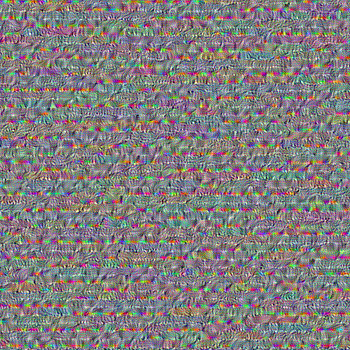

In [4]:
layer_name = "conv3_block2_out"
visualizer = FeatureVisualizer(model, layer_name=layer_name, width=400, height=400)
visualizer.fit(filter_index=0)
img = visualizer.show_image()